In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.constants as c
import astropy.units as u
import fnmatch

from astropy.table import Table

%matplotlib inline

In [16]:
# Read the VOTable to python and get the frequency, flux and flux error fields.
# See http://cdsportal.u-strasbg.fr/?target=V*%20DM%20Tau
wavelenth = [0.482, 0.763, 0.625, 0.352, 0.902, 3.55, 4.49, 5.73,
             7.87, 3.35, 4.6, 11.6, 22.1, 1300, 849, 1330, 887,
             1.65, 1.24, 2.16, 0.444, 0.554, 0.482, 0.763, 
             0.625] * u.micrometer
flux = [0.00429, 0.0344, 0.0174, 0.00186, 0.0358, 0.0505, 0.0362,
        0.0229, 0.0212, 0.0504, 0.0325, 0.0427, 0.31, 0.109, 0.237,
        0.0894, 0.237, 0.131, 0.105, 0.105, 0.00421, 0.00875, 0.0049,
        0.0332, 0.0153] * u.Jansky
eflux = [8e-05, None, None, 3e-05, None, 0.0009, 0.0007, 0.0006, 0.0006,
         0.0009, 0.0006, 0.0008, 0.009, 0.013, 0.012, 0.0031, 0.012,
         0.003, 0.002, 0.002, 0.0015, 0.00195, 0.00123, 0.0015,
         0.0024] * u.Jansky
band = ['SDSS:g', 'SDSS:i', 'SDSS:r', 'SDSS:u', 'SDSS:z', 'Spitzer/IRAC:3.6',
        'Spitzer/IRAC:4.5','Spitzer/IRAC:5.8','Spitzer/IRAC:8.0','WISE:W1',
        'WISE:W2','WISE:W3','WISE:W4',':=1.3mm',':=353GHz',':=225GHz',
        ':=338GHz','2MASS:H','2MASS:J','2MASS:Ks','Johnson:B','Johnson:V',
        'SDSS:g','SDSS:i','SDSS:r']
freq = c.c.to(u.cm / u.s) / wavelenth.to(u.cm) 

iSDSS = np.where(['SDSS' in n for n in band ])
iSpitzer = np.where(['Spitzer' in n for n in band ])
iWISE = np.where(['WISE' in n for n in band ])
i2MASS = np.where(['2MASS' in n for n in band ])

# Read the IRS data from CASSIS fits file
irs = astropy.io.fits.open('data/cassis_yaaar_spcfw_26141952t.fits')
irs_wave = irs[0].data[:,0] * u.micrometer
irs_flux = irs[0].data[:,1][irs_wave.argsort()] * u.Jansky
irs_eflux = irs[0].data[:,2][irs_wave.argsort()] * u.Jansky
irs_wave.sort()

irs_freq = c.c / irs_wave.to(u.meter) 

irs_band = np.empty(len(irs_wave), dtype="S10")
irs_band[:] = 'IRS'

[  3.35   4.6   11.6   22.1 ]


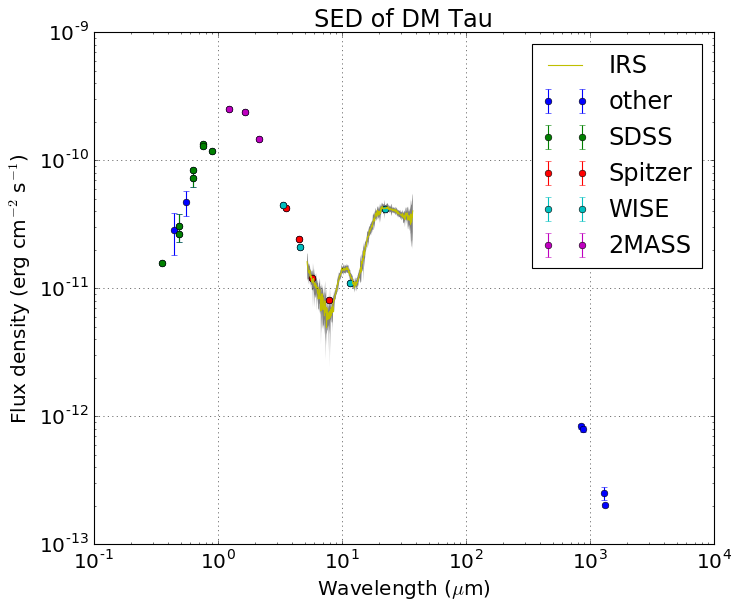

In [23]:
plt.style.use(['classic'])
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 18


plt.figure(figsize=(10,8))

wavelenth = (c.c/ freq).to(u.micrometer)

plt.errorbar(wavelenth.value, (flux*freq).to(u.erg/u.s/u.cm/u.cm).value, 
             yerr=(eflux*freq).to(u.erg/u.s/u.cm/u.cm).value, fmt='o', label='other')

plt.errorbar(wavelenth.value[iSDSS], (flux*freq).to(u.erg/u.s/u.cm/u.cm).value[iSDSS], 
             yerr=(eflux*freq).to(u.erg/u.s/u.cm/u.cm).value[iSDSS], fmt='o', label='SDSS')

plt.errorbar(wavelenth.value[iSpitzer], (flux*freq).to(u.erg/u.s/u.cm/u.cm).value[iSpitzer], 
             yerr=(eflux*freq).to(u.erg/u.s/u.cm/u.cm).value[iSpitzer], fmt='o', label='Spitzer')
print wavelenth.value[iWISE]

plt.errorbar(wavelenth.value[iWISE], (flux*freq).to(u.erg/u.s/u.cm/u.cm).value[iWISE], 
             yerr=(eflux*freq).to(u.erg/u.s/u.cm/u.cm).value[iWISE], fmt='o', label='WISE')

plt.errorbar(wavelenth.value[i2MASS], (flux*freq).to(u.erg/u.s/u.cm/u.cm).value[i2MASS], 
             yerr=(eflux*freq).to(u.erg/u.s/u.cm/u.cm).value[i2MASS], fmt='o', label='2MASS')

plt.fill_between(irs_wave.value, (irs_flux*irs_freq-irs_eflux*irs_freq).to(u.erg/u.s/u.cm/u.cm).value, 
                 (irs_flux*irs_freq+irs_eflux*irs_freq).to(u.erg/u.s/u.cm/u.cm).value, 
                 facecolor='gray', alpha=1.0, edgecolor='none')

plt.plot(irs_wave, (irs_flux*irs_freq).to(u.erg/u.s/u.cm/u.cm).value, label='IRS')

plt.title('SED of DM Tau')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux density (erg cm$^{-2}$ s$^{-1}$)')
plt.legend()
plt.grid()

plt.savefig('dm_tau_sed.png')

In [19]:
# Save the data for the purpose of later use

data_phot = Table({'wavelength': wavelenth,
             'freq': freq,
             'flux': flux,
             'eflux': eflux,
             'band': band},
             names=['wavelength','freq','flux','eflux','band'])
astropy.io.ascii.write(data_phot, 'data/dm_tau_phot.csv', format='csv')

data_irs = Table({'wavelength': irs_wave,
             'freq': irs_freq,
             'flux': irs_flux,
             'eflux': irs_eflux,
             'band': irs_band},
             names=['wavelength','freq','flux','eflux','band'])
astropy.io.ascii.write(data_irs, 'data/dm_tau_irs.csv', format='csv')

In [24]:
!pwd

/home/laci/tmp/radmc-3d-tutorial-master-a5bb663ef8c62f4950a924e7f7f7c1c4fdf10741
